### Import Libraries

Built in Python imports

In [1]:
import time


Additional CPU imports

In [2]:
import numpy as np;print('numpy Version:', np.__version__)
import pandas as pd;print('pandas Version:', pd.__version__)
import sklearn
## Visulaization libraries 
import ipyvolume as ipv
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

numpy Version: 1.16.4
pandas Version: 0.24.2


Import Algorithms and Dataset libraries 

In [3]:

 
from sklearn import datasets; 
from sklearn.metrics import confusion_matrix, accuracy_score

Imports for GPU dataset and algorithms accelerations 

In [4]:
import cupy;print('cupy Version', cupy.__version__)
import cudf;print('cudf Version', cudf.__version__)


import rapids_lib_v8 as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(rl)

cupy Version 6.2.0
cudf Version 0.9.0


<module 'rapids_lib_v8' from '/rapids/notebooks/ml_tutorial/testing/rapids_lib_v8.py'>

### Data Generation

We will generate data shapes [coordinate lists] and hand them to the GPU. The GPU will randomly build 3D blobs [ cupy.random.normal ] around each coordinate point to create a much larger, noisier, and more realistic dataset.

Using this concept we offer the following dataset variations:
1. Helix - two entwined coils, inspired by DNA casing
2. Whirl - an increasingly unwinding Helix 

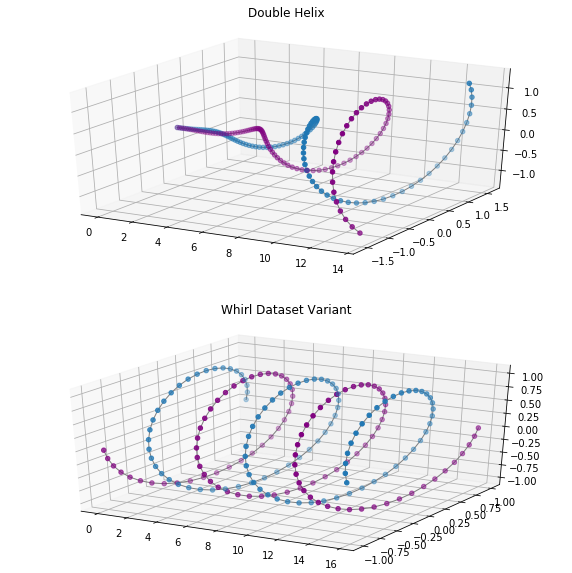

In [5]:
rl.plot_dataset_variants()

In order to generate the dataset with either of two variants, take a look into the library and create your own! 

In [6]:
help(rl.gen_blob_coils)

Help on function gen_blob_coils in module rapids_lib_v8:

gen_blob_coils(nBlobPoints=100, nCoordinates=100, coilType='whirl', coilDensity=6.25, sdevScales=[0.05, 0.05, 0.05], noiseScale=0.2, shuffleFlag=False, rSeed=0, plotFlag=True, maxSamplesToPlot=50000)



This is the set of values we used for our experiment: 

In [7]:
nBlobPoints = 500
nCoordinates =10
sdevScales = [ .01, .01, .01]
noiseScale = 1/5.
coilDensity = 8

In [8]:
data, labels, t_gen = rl.gen_blob_coils( coilType='helix', 
                                        shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 5000
generating blobs; # points = 5000
time to generate data on GPU = 1.5835137367248535
	 plotting data - stride = 1 


This rapids library will return cudf Dataframe object as expected. Let's check .

In [9]:
print ('Type of dataset rl returned is', type(data))

Type of dataset rl returned is <class 'cudf.dataframe.dataframe.DataFrame'>


### Split Training and Testing data

In [10]:
expLog = {}

In [11]:
## helper function to split the dataset 
def split_train_test_nfolds ( dataDF, labelsDF, nFolds = 10, seed = 1, nSamplesToSwap = 50 ):
    print('splitting data into training and test set')
    startTime = time.time()
    
    nSamplesPerFold = int(dataDF.shape[0] // nFolds)
    sampleRanges = np.arange(nFolds) * nSamplesPerFold
        
    np.random.seed(seed)
    foldStartInds = np.random.randint(0, nFolds-1, size = nFolds)
    foldEndInds = foldStartInds + 1 
    
    testFold = np.random.randint(0,nFolds-1)
    trainInds = None; testInds = None
    
    for iFold in range( nFolds ):
        lastFoldFlag = ( iFold == nFolds-1 )
        if lastFoldFlag: foldInds = np.arange(sampleRanges[iFold], dataDF.shape[0] )
        else: foldInds = np.arange(sampleRanges[iFold], sampleRanges[iFold+1])
        
        if iFold == testFold: testInds = foldInds
        else:
            if trainInds is None: trainInds = foldInds
            else: trainInds = np.concatenate([trainInds, foldInds])
                
    # swap subset of train and test samples [ low values require higher model generalization ]
    if nSamplesToSwap > 0:
        trainIndsToSwap = np.random.permutation(trainInds.shape[0])[0:nSamplesToSwap]
        testIndsToSwap = np.random.permutation(testInds.shape[0])[0:nSamplesToSwap]        
        trainBuffer = trainInds[trainIndsToSwap].copy()
        trainInds[trainIndsToSwap] = testInds[testIndsToSwap]
        testInds[testIndsToSwap] = trainBuffer
    
    # build final dataframes
    trainDF = dataDF.iloc[trainInds]
    testDF = dataDF.iloc[testInds]
    trainLabelsDF = labelsDF.iloc[trainInds]
    testLabelsDF = labelsDF.iloc[testInds]                
    
    return trainDF, trainLabelsDF, testDF, testLabelsDF, time.time() - startTime


### Rescale / Normalize the data

In [12]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

## GPU vs CPU work 

We will use two above helper functions to split our dataset into trainin and testing and normalize it afterwards.
Before we dive deep into the work i want to make a note about variable naming:

We will use **_pDF** (as Pandas DataFrame) sufix to our varaible names to emphasize that the variable resides on CPU. Also , we will use **_cDF** (cudf DataFrame) to recognize the variables that are using GPU acclerated libraries (cudf and cuml)

### CPU split & scale

In order to have our functions using CPU only we will use use pandas.

In [13]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = split_train_test_nfolds ( data.to_pandas(), 
                                                                                                     labels.to_pandas(), 
                                                                                                     nSamplesToSwap = 20 )

# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = rl.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.00339 s ]
 + adding log entry [ CPU_scale_train_data     :   0.05995 s ]
 + adding log entry [ CPU_scale_test_data      :   0.05487 s ]


Let's now take a look into our dataset, shape and datatypes : 


In [14]:
print(testData_pDF.head());
print (trainData_pDF.shape)
print('trainData_pDF: ', trainData_pDF.shape, type(trainData_pDF), 'trainLabels_pDF: ', trainLabels_pDF.shape, type(trainLabels_pDF))

             x         y         z
5000  0.187829 -0.021646  1.669398
5001  0.187829 -0.454661 -1.337261
5002  0.187232  0.102232  1.365948
5003  0.187232 -0.330783 -1.640711
5004  0.205688  0.305237  1.527727
(9000, 3)
trainData_pDF:  (9000, 3) <class 'pandas.core.frame.DataFrame'> trainLabels_pDF:  (9000, 1) <class 'pandas.core.frame.DataFrame'>


### GPU split & scale

In [15]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = split_train_test_nfolds ( data, labels, nSamplesToSwap = 20)

# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['GPU_split_train_test', t_split],
                                 ['GPU_scale_train_data', t_scaleTrain],
                                 ['GPU_scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ GPU_split_train_test     :   0.29330 s ]
 + adding log entry [ GPU_scale_train_data     :   0.00906 s ]
 + adding log entry [ GPU_scale_test_data      :   0.00500 s ]


In [16]:
print(trainData_cDF.head());
print (trainData_cDF.shape)
print('trainData_cDF: ', trainData_cDF.shape, type(trainData_cDF), 'trainLabels_cDF: ', trainLabels_cDF.shape, type(trainLabels_cDF))

          x         y         z
0 -1.447932  1.004364 -0.128349
1 -1.447932 -1.489269 -0.128349
2 -1.428691  1.119271 -0.369940
3 -1.428691 -1.374362 -0.369940
4 -1.512850  1.767927 -0.043988
(9000, 3)
trainData_cDF:  (9000, 3) <class 'cudf.dataframe.dataframe.DataFrame'> trainLabels_cDF:  (9000, 1) <class 'cudf.dataframe.dataframe.DataFrame'>


In [17]:
rl.plot_train_test(trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF)

In [20]:
# %store trainData_cDF
# %store trainLabels_cDF
# %store testData_cDF 
%store testLabels_cDF

Stored 'testLabels_cDF' (DataFrame)


In [19]:
%store expLog
%store trainData_pDF
%store trainLabels_pDF 
%store testData_pDF
%store testLabels_pDF

Stored 'expLog' (dict)
Stored 'trainData_pDF' (DataFrame)
Stored 'trainLabels_pDF' (DataFrame)
Stored 'testData_pDF' (DataFrame)
Stored 'testLabels_pDF' (DataFrame)
